In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.naive_bayes import naive_bayes
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re

In [122]:
resumes = pd.read_csv("data/Resume.csv",usecols=[0, 1, 3])
resumes

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR
...,...,...,...
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION
2481,31605080,GEEK SQUAD AGENT Professional...,AVIATION
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION


In [123]:
resumes.rename(columns={
    "ID": "id",
    "Resume_str": "resume_text",
    "Category": "category"
}, inplace=True)

In [124]:
resumes["resume_text"][0]

"         HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, inventory control, loss pr

In [125]:
def cleaning(string: str):
    lemmatizer = WordNetLemmatizer()
    output = re.sub("[^\w]", " ", string)
    output = re.sub("\s+", " ", output)
    output = output.strip().lower().split()
    output = [lemmatizer.lemmatize(word) for word in output if word not in stopwords.words("english")]
    output = " ".join(output)
    
    return output

In [126]:
resumes["resume_text"] = resumes["resume_text"].apply(cleaning)

In [127]:
resumes["resume_text"][0]

'hr administrator marketing associate hr administrator summary dedicated customer service manager 15 year experience hospitality customer service management respected builder leader customer focused team strives instill shared enthusiastic commitment customer service highlight focused customer satisfaction team management marketing savvy conflict resolution technique training development skilled multi tasker client relation specialist accomplishment missouri dot supervisor training certification certified ihg customer loyalty marketing segment hilton worldwide general manager training certification accomplished trainer cross server hospitality system hilton onq micros opera pm fidelio opera reservation system or holidex completed course seminar customer service sale strategy inventory control loss prevention safety time management leadership performance assessment experience hr administrator marketing associate hr administrator dec 2013 current company name city state help develop poli

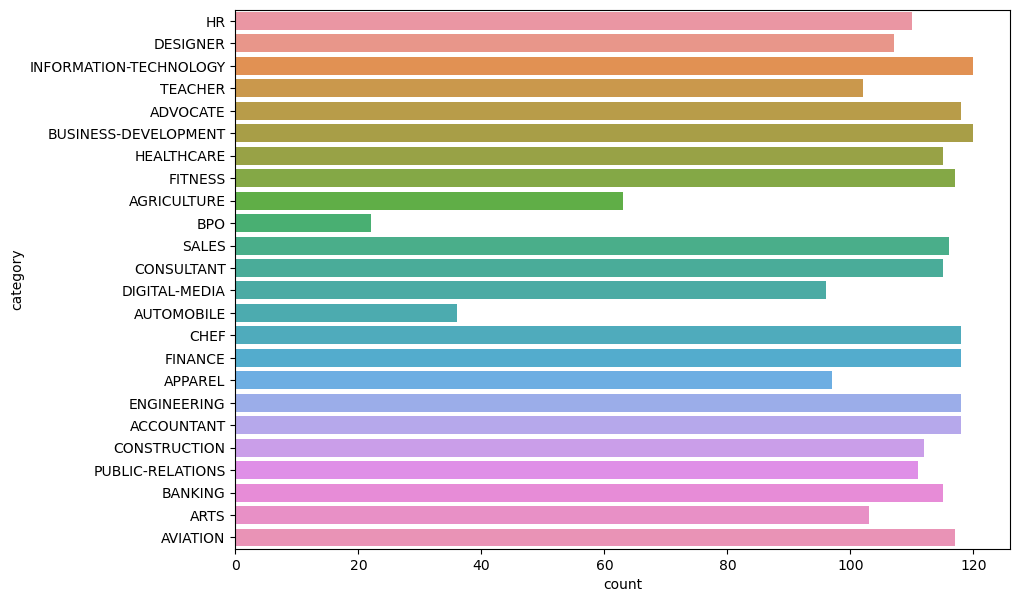

In [128]:
plt.figure(figsize=(10, 7))
sns.countplot(y=resumes["category"])
plt.show()

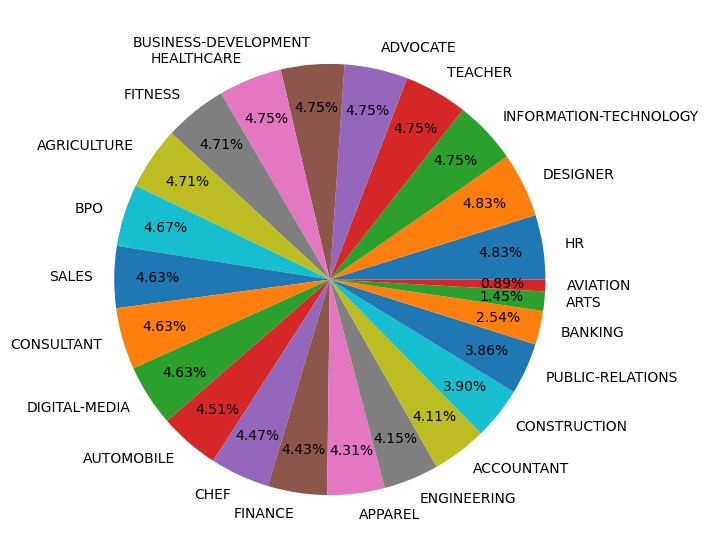

In [129]:
plt.figure(figsize=(12, 7))
plt.pie(resumes["category"].value_counts(), labels=resumes["category"].unique(), autopct="%.2f%%", pctdistance=0.8)
plt.show()

In [168]:
from sklearn.utils import resample

# Define the maximum count among all categories
max_count = resumes['category'].value_counts().max()

# Resample each category to match the maximum count
balanced_data = []
for category in resumes['category'].unique():
    category_data = resumes[resumes['category'] == category]
    if len(category_data) < max_count:
        # Perform oversampling for categories with fewer samples
        balanced_category_data = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:
        # Perform undersampling for categories with more samples
        balanced_category_data = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balanced_category_data)

# Concatenate the balanced data for all categories
balanced_resumes = pd.concat(balanced_data)

In [170]:
balanced_resumes["category"].value_counts()

HR                        120
DESIGNER                  120
ARTS                      120
BANKING                   120
PUBLIC-RELATIONS          120
CONSTRUCTION              120
ACCOUNTANT                120
ENGINEERING               120
APPAREL                   120
FINANCE                   120
CHEF                      120
AUTOMOBILE                120
DIGITAL-MEDIA             120
CONSULTANT                120
SALES                     120
BPO                       120
AGRICULTURE               120
FITNESS                   120
HEALTHCARE                120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  120
TEACHER                   120
INFORMATION-TECHNOLOGY    120
AVIATION                  120
Name: category, dtype: int64

In [172]:
inp = balanced_resumes["resume_text"]
target = balanced_resumes["category"]
x_train, x_test, y_train, y_test = train_test_split(inp, target, test_size=0.2, random_state=42)

In [236]:
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [237]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train_tfidf, y_train)
predictions = rf_classifier.predict(x_test_tfidf)

In [238]:
accuracy_score(y_test, predictions)

0.8524305555555556

In [239]:
print(classification_report(y_test, predictions))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.76      0.95      0.84        20
              ADVOCATE       0.85      0.79      0.82        29
           AGRICULTURE       0.95      0.91      0.93        23
               APPAREL       0.86      0.82      0.84        22
                  ARTS       1.00      0.67      0.80        24
            AUTOMOBILE       1.00      0.68      0.81        19
              AVIATION       0.93      0.96      0.95        28
               BANKING       0.94      0.68      0.79        22
                   BPO       1.00      1.00      1.00        15
  BUSINESS-DEVELOPMENT       0.52      0.67      0.59        18
                  CHEF       0.87      0.96      0.92        28
          CONSTRUCTION       0.96      0.96      0.96        25
            CONSULTANT       0.96      0.71      0.81        31
              DESIGNER       0.84      0.96      0.90        28
         DIGITAL-MEDIA       0.75      

<Axes: >

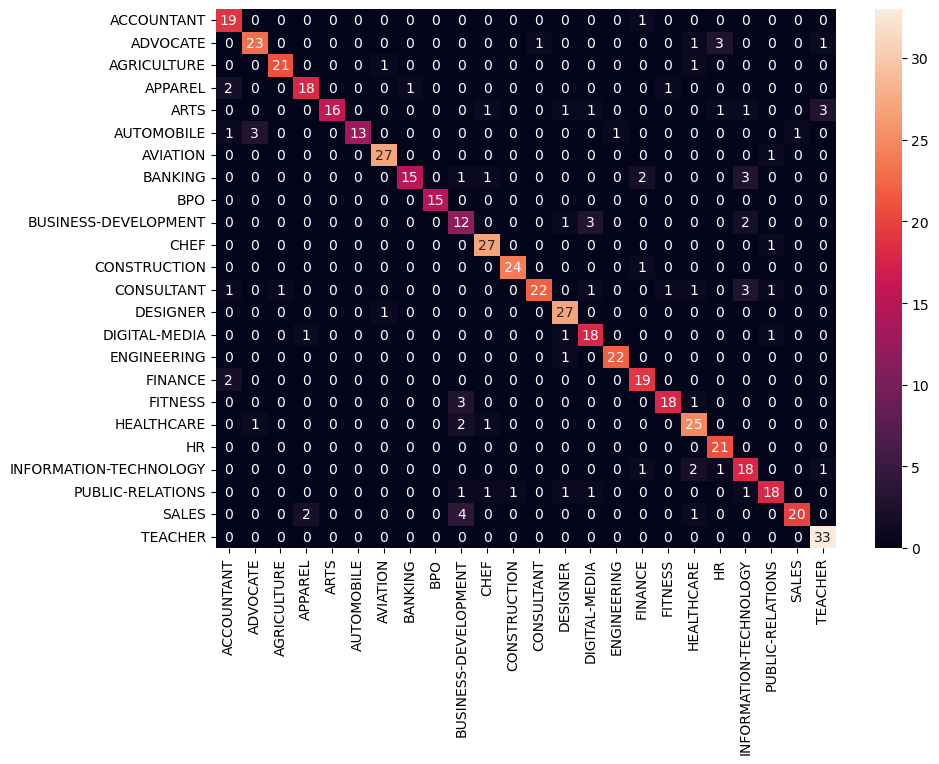

In [240]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, xticklabels=rf_classifier.classes_, 
            yticklabels=rf_classifier.classes_, fmt="d")

In [241]:
def predict_category(resume):
    resume = cleaning(resume)
    resume = tfidf.transform([resume])
    predicted = rf_classifier.predict(resume[0])
    
    return predicted[0]

In [243]:
predict_category( """Objective:
Dedicated and results-oriented Banking professional with a strong background in financial analysis and customer service seeking opportunities to contribute to a reputable financial institution. Eager to leverage expertise in risk management, investment strategies, and relationship building to drive business growth and client satisfaction.

Education:
- Bachelor of Business Administration in Finance, XYZ University, GPA: 3.8/4.0
- Certified Financial Analyst (CFA) Level I Candidate

Skills:
- Proficient in financial modeling and analysis using Excel, Bloomberg Terminal, and other financial software
- Extensive knowledge of banking products and services, including loans, mortgages, and investment products
- Strong understanding of regulatory compliance and risk management practices in the banking industry
- Excellent communication and interpersonal skills, with a focus on building rapport with clients and colleagues
- Ability to work efficiently under pressure and adapt to changing market conditions

Experience:
Financial Analyst | ABC Bank
- Conducted financial analysis and risk assessment for corporate clients, including credit analysis, financial statement analysis, and cash flow modeling
- Developed customized financial solutions to meet clients' needs and objectives, resulting in increased revenue and client retention
- Collaborated with cross-functional teams to identify new business opportunities and optimize existing processes

Customer Service Representative | DEF Bank
- Provided exceptional customer service to bank clients, addressing inquiries, resolving issues, and promoting banking products and services
- Processed transactions accurately and efficiently, including deposits, withdrawals, and account transfers
- Educated customers on various banking products and services, helping them make informed financial decisions

Internship | GHI Investments
- Assisted portfolio managers with investment research and analysis, including industry and company-specific research, financial modeling, and performance analysis
- Prepared investment presentations and reports for clients, highlighting investment opportunities and performance metrics
- Conducted market research and analysis to identify trends and opportunities in the financial markets

Certifications:
- Certified Financial Planner (CFP)
- Series 7 and Series 63 Securities Licenses

Languages:
- English (Native)
- Spanish (Proficient)

""")

'BANKING'

In [244]:
import pickle

In [246]:
pickle.dump(rf_classifier,open('models/rf_classifier_categorization.pkl','wb'))
pickle.dump(tfidf,open('models/tfidf_vectorizer_categorization.pkl','wb'))